<a href="https://colab.research.google.com/github/s2cretjuju/first-repository/blob/master/wrap_up/%5BWrapUp%5D_20251125_%EC%8B%9C%EA%B3%84%EC%97%B4_%EB%B6%84%EC%84%9D_%EC%A0%84%EB%A0%A5_%EC%82%AC%EC%9A%A9%EB%9F%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**시계열 분석 - 시간의 흐름 속 패턴 예측**

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [44]:
df = pd.read_csv('/content/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

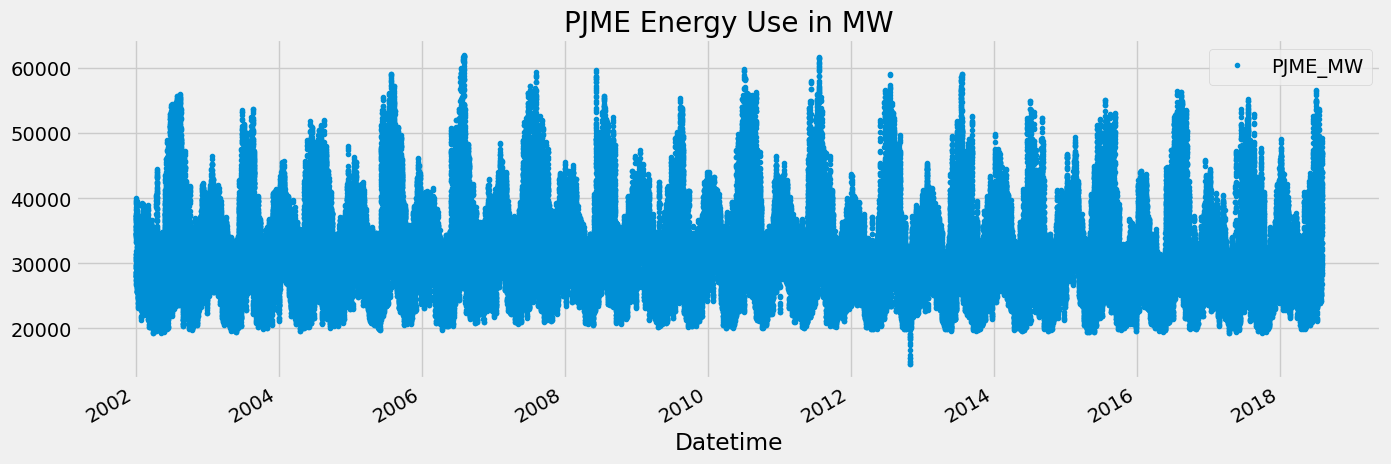

In [45]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

#**train/test 분리**

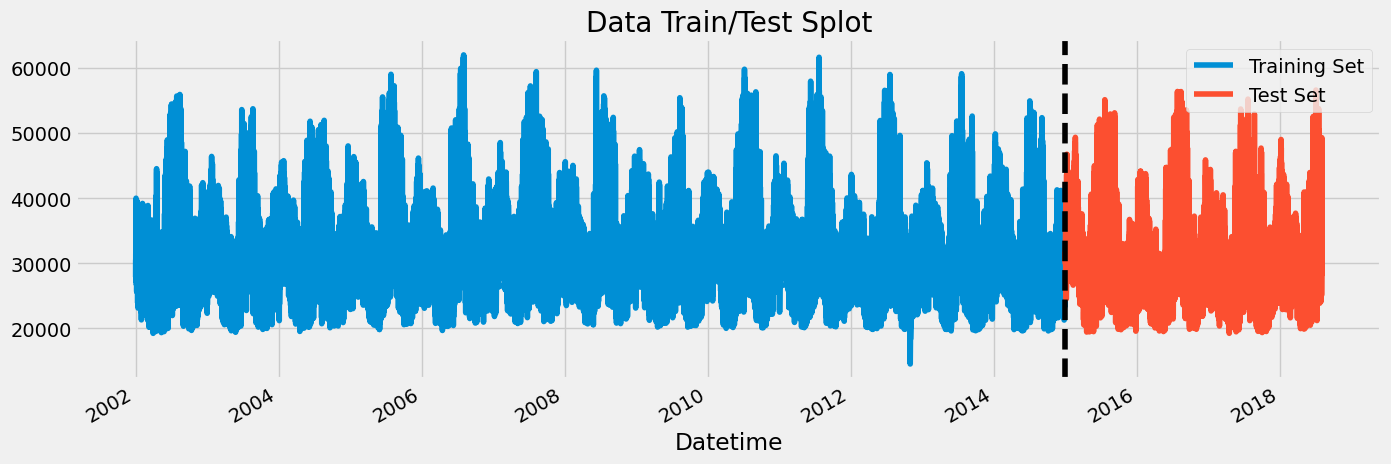

In [46]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax = ax, label = 'Training Set', title = 'Data Train/Test Splot')
test.plot(ax = ax, label = 'Test Set')
ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

파란선 - 학습 데이터 (2002 - 2014.12.31)

빨간선 - 테스트 데이터 (2015.01.01 - 2018)

전력 사용량의 계절성 확인 가능

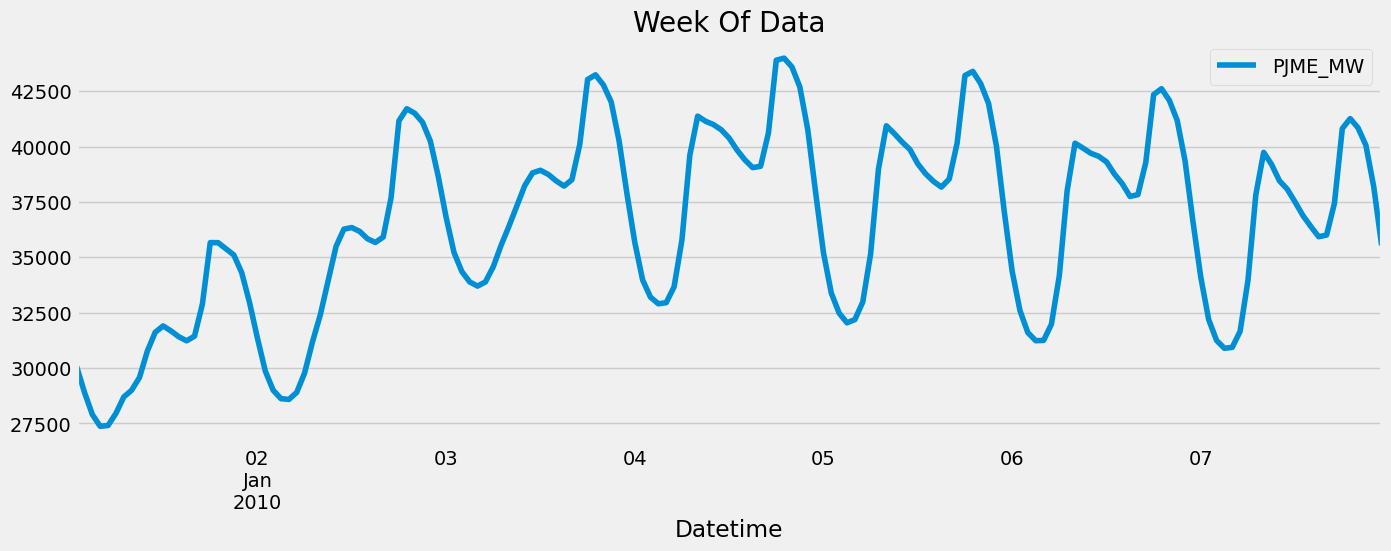

In [47]:
# 데이터프레임의 인덱스(시간)를 기준으로 오름차순 정렬
df = df.sort_index()

df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

1. 일일 주기성
* 그래프가 하루에 한 번씩 솟아오르는 파동을 그림
* 밤/새벽: 사람들이 자는 시간에는 전력 사용량 감소
* 낮/저녁: 활동 시간에는 사용량 급증
* 모델에 지금이 몇 시인지 정보 제공할 필요 있음

2. 주간 주기성
* 주말/공휴일: 사용량 적음
* 평일: 사용량 많음
* 모델에 요일/공휴일에 대한 정보 제공할 필요 있음

#**Feature Engineering**

In [48]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

#**피처 시각화**

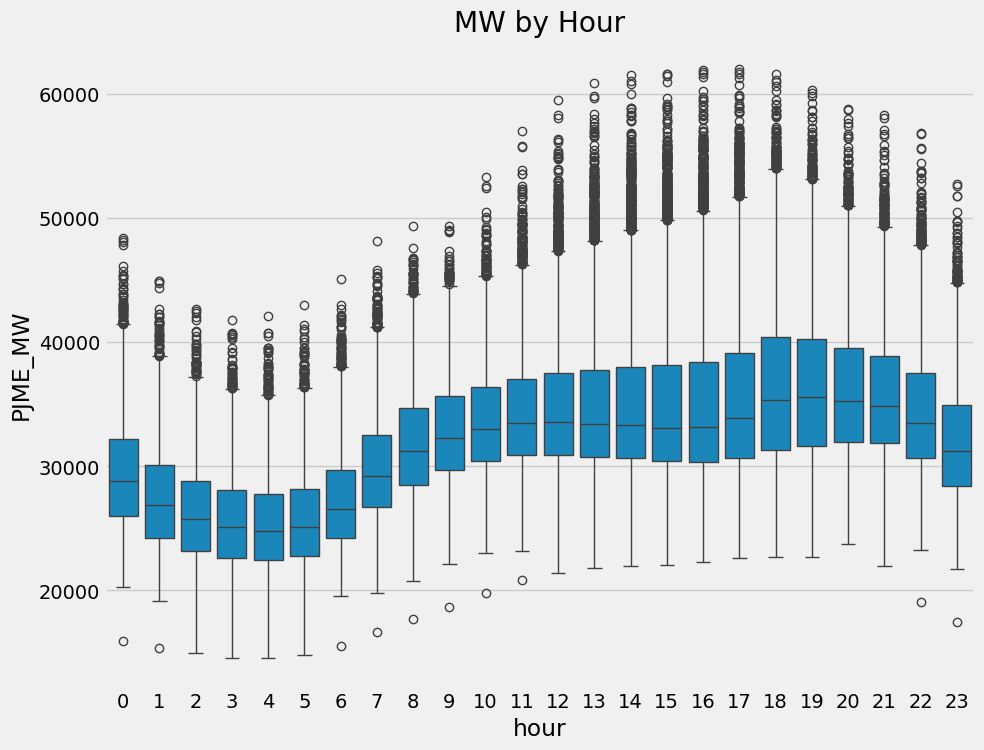

In [49]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

/tmp/ipython-input-2202713226.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


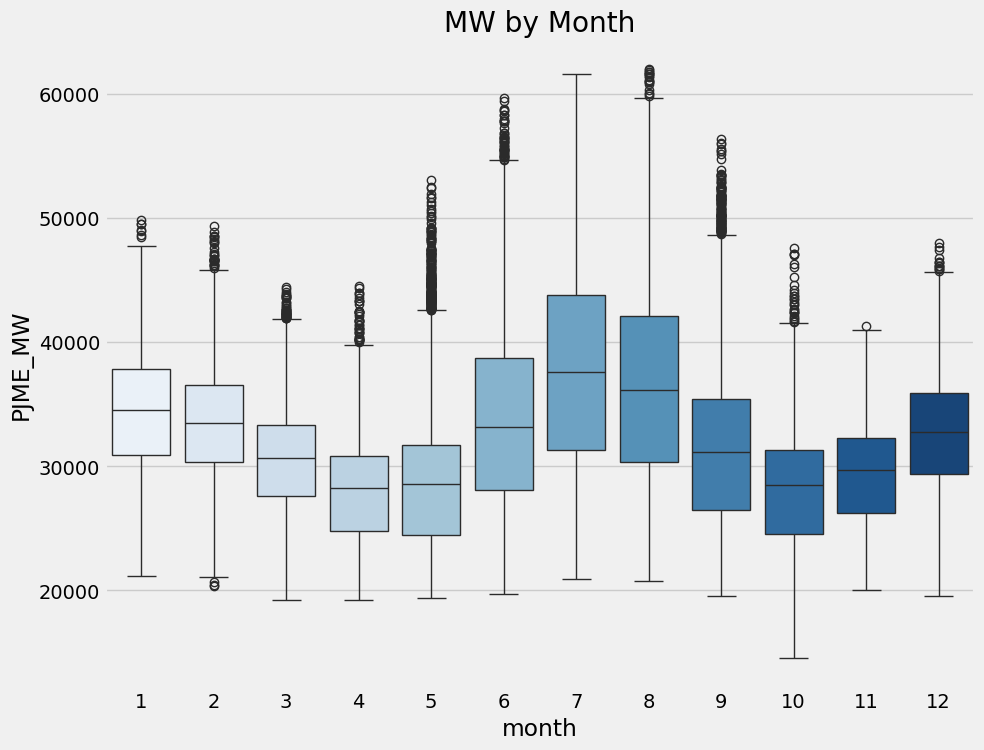

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

#**모델 생성**

In [51]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [53]:
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

#**Feature Importance**

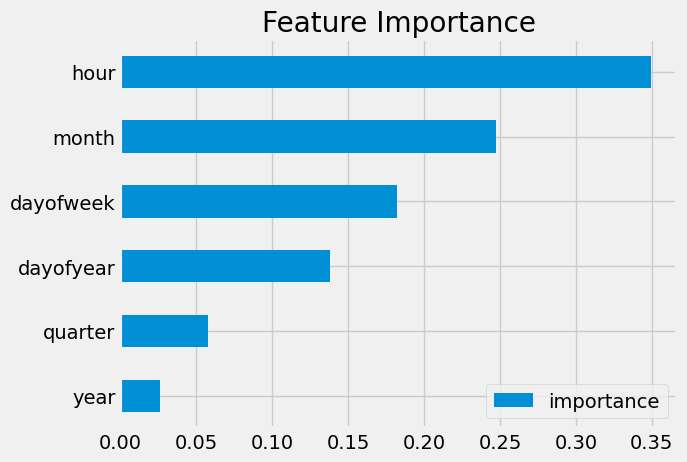

In [54]:
fi = pd.DataFrame(data = reg.feature_importances_,
                  index = reg.feature_names_in_,
                  columns = ['importance'])
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

#**Forecast on Test**

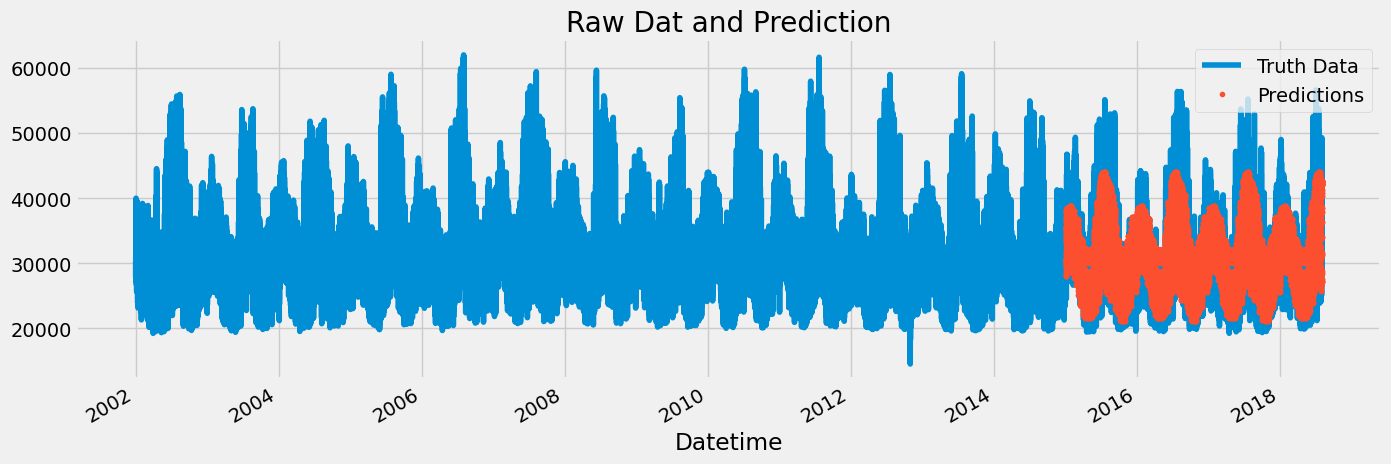

In [56]:
test['prediction'] = reg.predict(X_test)
df['prediction'] = np.nan # Ensure the column exists, initialized with NaNs

# Ensure test has a unique index before assigning to df
test_unique = test[~test.index.duplicated(keep='first')]

# Assign predictions from the unique-indexed test to df
df.loc[test_unique.index, 'prediction'] = test_unique['prediction'] # Assign predictions to corresponding indices

ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

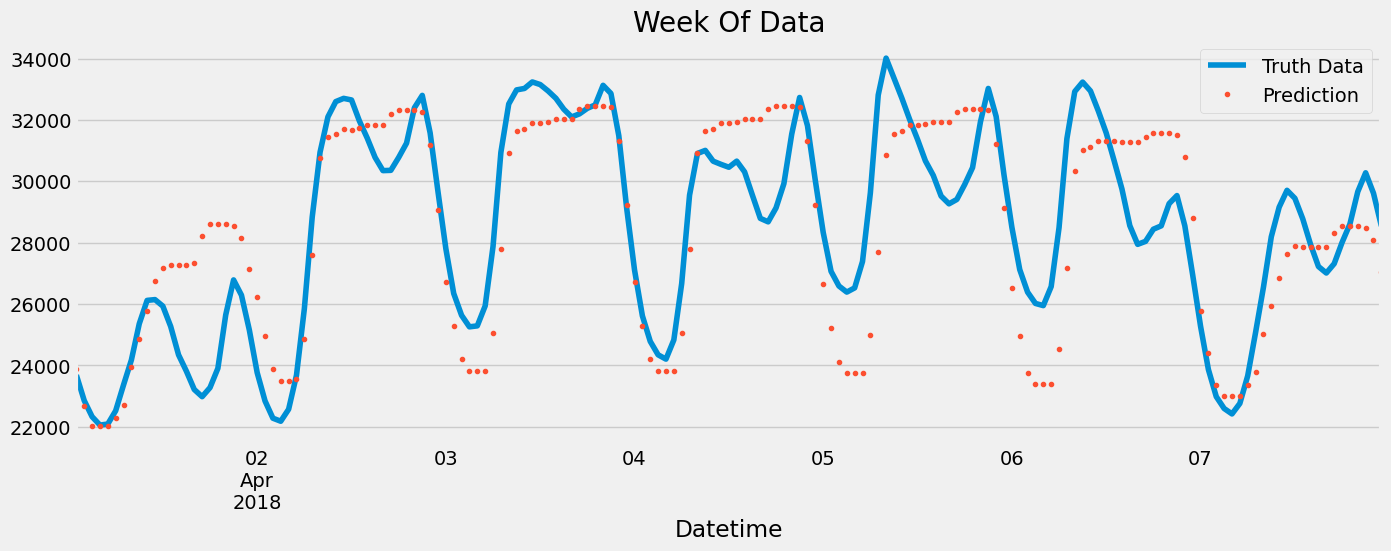

In [57]:
df = df.sort_index()

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

#**Score (RMSE)**

In [58]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


In [60]:
# 1. 평균값(Mean)만 딱 보기
print(df['PJME_MW'].mean())

# 2. 전체적인 통계 요약 보기 (추천 ⭐)
print(df['PJME_MW'].describe())

32080.222830648156
count    145366.000000
mean      32080.222831
std        6464.012166
min       14544.000000
25%       27573.000000
50%       31421.000000
75%       35650.000000
max       62009.000000
Name: PJME_MW, dtype: float64


32,080 중에 3,726이 틀렸으므로 오차율은 대략 11.6%

#**Calculate Error**

In [59]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

,error
date,
2016-08-13,12879.484619
2016-08-14,12772.887207
2015-02-20,11186.031494
2016-09-09,10966.513102
2016-09-10,10889.102214
2018-01-06,10642.975830
2016-08-12,10041.172689
2015-02-21,9988.168783
2015-02-16,9900.809326


모델이 가장 크게 틀린 날들 - 날씨/기온에 대한 정보가 없는 날